In [150]:
import polars as pl 
import polars.selectors as cs 
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from yahoo_fin.stock_info import get_data
import phoenix as px 
import umap
from sklearn.linear_model import LinearRegression
import utils
from dateutil.relativedelta import relativedelta 
import numpy as np
import seaborn.objects as so 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

to test against MSCI: recuced with umap (2,3,?), and PCA

test against pct_change and raw data

## Getting data

In [2]:
sentences = pl.read_parquet(r"C:\Users\faune\Desktop\thesis\daily_headlines.parquet")
msci_world = get_data(ticker="^990100-USD-STRD", start_date="2008-01-01", end_date="2016-01-01")
msci_close = pl.DataFrame(msci_world[['close']].dropna().pct_change().reset_index())
to_join = msci_close.drop_nulls().with_columns(pl.col('index').cast(pl.Date)).rename({'index': 'date'})
sentences = sentences.with_columns(pl.col('date').cast(pl.Date))
frame = sentences.join(to_join, on='date').with_columns(pl.col('date').dt.quarter().alias('quarter'), pl.col('date').dt.year().alias('year'))
reducer = umap.UMAP()
reduced = reducer.fit_transform(frame.select('embeddings').to_series().to_list())

In [39]:
frame = frame.with_columns(pl.Series(name = 'reduced', values = reduced))
# sns.scatterplot(data = frame.with_columns(pl.col('reduced').list.to_struct()).unnest('reduced').rename({'field_0':'x', 'field_1':'y'}).select('x','y', 'label').to_pandas(), x= 'x', y = 'y', hue='label', palette = sns.cubehelix_palette(n_colors=3))

## Getting lineplots

In [162]:
def get_linear_regression(x_col: str, y_col: str, df: pl.DataFrame):
    model = LinearRegression()
    X = df.select(pl.col(x_col)).to_series().to_list()
    y = df.select(pl.col(y_col)).to_series().to_list()
    
    ind = -int(len(X)/3)

    reg = model.fit(X[:ind], y[:ind])

    out_of_sample = np.dot(a=reg.coef_, b=np.transpose(X[ind:]))
    in_sample = reg.predict(X[:ind])
    predicted = np.append(in_sample, out_of_sample)

    with_predicted = df.with_columns(pl.Series(name = "predictions", values = predicted))
    with_predicted = with_predicted.select('date', y_col, 'predictions') 

    sns.set_theme(context='notebook', rc={'figure.figsize':(20,5)}, palette=sns.cubehelix_palette(2), style='white')
    sns.lineplot(data = with_predicted.to_pandas().set_index('date'))
    plt.axvline(with_predicted.select('date')[ind].to_series().to_list()[0], 0,1, color = 'blue')
    plt.text(x=with_predicted.select('date')[ind].to_series().to_list()[0] + relativedelta(years=1), y = 0.075, s = "Out of Sample")

    # print("Coefficients: \n", reg.coef_)
    plt.text(x=with_predicted.select('date')[ind].to_series().to_list()[0] - relativedelta(years=3),y=-0.2,s=f"Mean squared error (in sample): {mean_squared_error(y[:ind], in_sample):.2f}")
    plt.text(x=with_predicted.select('date')[ind].to_series().to_list()[0] - relativedelta(years=3),y=-0.25,s=f"Coefficient of determination (in sample): {r2_score(y[:ind], in_sample):.2f}")
    plt.text(x=with_predicted.select('date')[ind].to_series().to_list()[0] - relativedelta(years=3),y=-0.3,s=f"Mean squared error (out of sample): {mean_squared_error(y[ind:], out_of_sample):.2f}")
    plt.text(x=with_predicted.select('date')[ind].to_series().to_list()[0] - relativedelta(years=3),y=-0.35,s= f"Coefficient of determination (out of sample): {r2_score(y[ind:], out_of_sample):.2f}")
    return

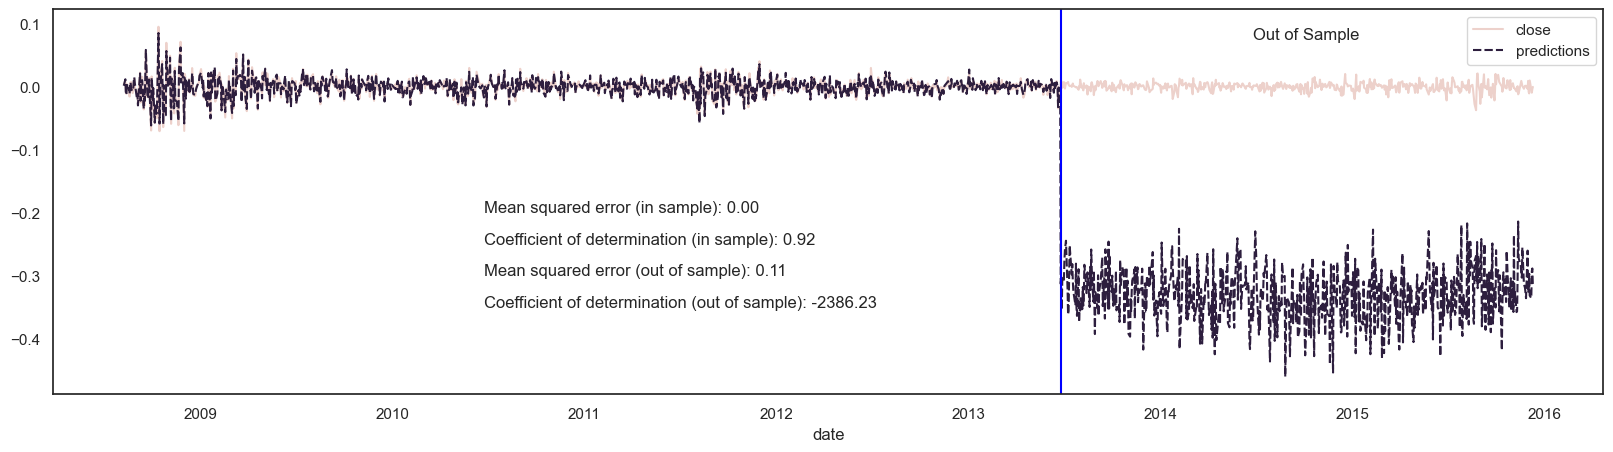

In [163]:
get_linear_regression(x_col='embeddings', y_col='close', df=frame)